unsupervised: 
	phi: 0.5772652481723749
	mu_0: [-1.02823909 -0.99553849]
	mu_1: [1.00701263 1.00538482]
	sigma_0: [[0.3726962  0.32798147]
 [0.32798147 0.78952205]]
	sigma_1: [[0.70183308 0.1340817 ]
 [0.1340817  0.30353389]]
total steps:  48

semi-supervised: 
	phi: 0.5863498817945461
	mu_0: [-1.04546727 -1.02704636]
	mu_1: [0.98763329 0.99661118]
	sigma_0: [[0.36018609 0.30853357]
 [0.30853357 0.75384027]]
	sigma_1: [[0.7196797  0.1437903 ]
 [0.1437903  0.30853791]]
total steps:  4

scikit learn:
	phi: 0.59647894226803
	mu_0: [-1.06169376 -1.0563389 ]
	mu_1: [0.96408565 0.98206315]
	sigma_0: [[0.35027155 0.29629092]
 [0.29629092 0.73083581]]
	sigma_1: [[0.74510804 0.16156928]
 [0.16156928 0.32021029]]

99.4% of forecasts matched.


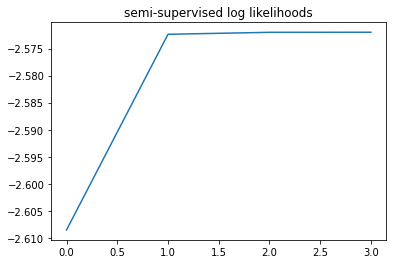

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt


def GMM_sklearn(x, weights=None, means=None, covariances=None):
    model = GaussianMixture(n_components=2,
                            covariance_type='full',
                            tol=0.01,
                            max_iter=1000,
                            weights_init=weights,
                            means_init=means,
                            precisions_init=covariances)
    model.fit(x)
    print("\nscikit learn:\n\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (model.weights_[1], model.means_[0, :], model.means_[1, :], model.covariances_[0, :], model.covariances_[1, :]))
    return model.predict(x), model.predict_proba(x)[:,1]


def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params


def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    phi = x_labeled[y_labeled == 1].shape[0] / n
    mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
    mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
    sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias= True)
    sigma1 = np.cov(x_labeled[y_labeled == 1].T, bias=True)
    return {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}


def e_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params


def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods




if __name__ == '__main__':
    data_unlabeled = pd.read_csv('unlabeled.csv')
    x_unlabeled = data_unlabeled[["x1", "x2"]].values


    print("unsupervised: ")
    random_params = initialize_random_params()
    unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
    print("total steps: ", len(unsupervised_loglikelihoods))
    plt.plot(unsupervised_loglikelihoods)
    plt.title("unsupervised log likelihoods")
    plt.savefig("unsupervised.png")
    plt.close()


    print("\nsemi-supervised: ")
    data_labeled = pd.read_csv('labeled.csv')
    x_labeled = data_labeled[["x1", "x2"]].values
    y_labeled = data_labeled["y"].values
    learned_params = learn_params(x_labeled, y_labeled)
    semisupervised_forecasts, semisupervised_posterior, semisupervised_loglikelihoods = run_em(x_unlabeled, learned_params)
    print("total steps: ", len(semisupervised_loglikelihoods))
    plt.plot(semisupervised_loglikelihoods)
    plt.title("semi-supervised log likelihoods")
    plt.savefig("semi-supervised.png")

    learned_params = learn_params(x_labeled, y_labeled)
    weights = [1 - learned_params["phi"], learned_params["phi"]]
    means = [learned_params["mu0"], learned_params["mu1"]]
    covariances = [learned_params["sigma0"], learned_params["sigma1"]]
    sklearn_forecasts, posterior_sklearn = GMM_sklearn(x_unlabeled, weights, means, covariances)
    
    output_df = pd.DataFrame({'semisupervised_forecasts': semisupervised_forecasts,
                              'semisupervised_posterior': semisupervised_posterior[:, 1],
                              'sklearn_forecasts': sklearn_forecasts,
                              'posterior_sklearn': posterior_sklearn})

    print("\n%s%% of forecasts matched." % (output_df[output_df["semisupervised_forecasts"] == output_df["sklearn_forecasts"]].shape[0] /output_df.shape[0] * 100))

